Using rating columns: ['Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on relevance']


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.



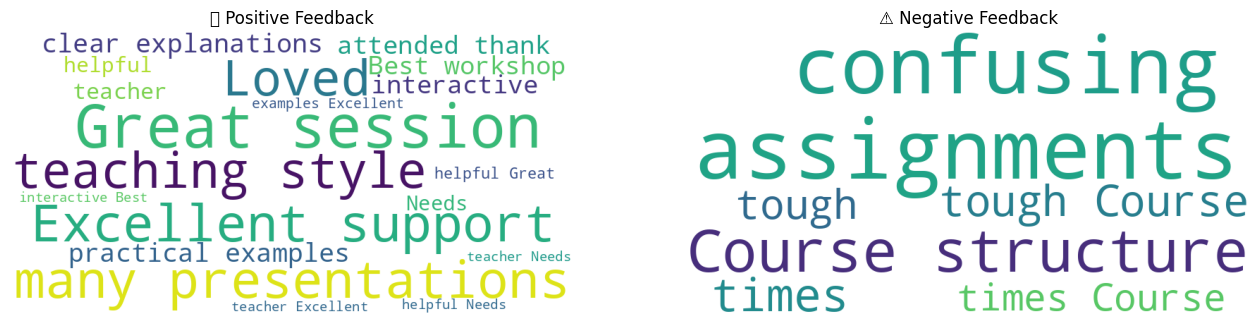

⭐ Overall: 5.92
✅ Highest Rated: Well versed with the subject 7.497502497502498
⚠️ Lowest Rated: Degree of difficulty of assignments 5.430569430569431
📊 Sentiment %: {'Positive': 74.7, 'Negative': 25.3}

🔮 Recommendations:
- ⚠️ Improve 'Degree of difficulty of assignments' as it has the lowest rating (5.4).
- 📌 Address recurring complaints to reduce negative sentiment.
- 💚 Leverage positive feedback in promotional material.
📄 Saved Feedback_Report.docx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =========================================
# 📊 COLLEGE EVENT FEEDBACK ANALYSIS – NEXT LEVEL
# =========================================

# --- Step 1: Imports & Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from docx import Document
from docx.shared import Inches
from textblob import TextBlob
import os, re
import plotly.io as pio
pio.renderers.default = "colab"   # interactive in Colab

# --- Step 2: Load Data ---
try:
    df
except NameError:
    from google.colab import files
    import io
    uploaded = files.upload()
    fname = next(iter(uploaded))
    df = pd.read_csv(io.BytesIO(uploaded[fname]))

# Drop unwanted columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Identify rating columns automatically
if 'rating_cols' not in globals():
    possible = [c for c in df.columns if c.lower() not in ['student id','student_id','feedback_text','comments','comments_text','feedback']]
    rating_cols = [c for c in possible if pd.api.types.is_numeric_dtype(df[c])]
    if len(rating_cols) == 0:
        rating_cols = possible
print("Using rating columns:", rating_cols)

# --- Step 3: Average Ratings Chart ---
avg_ratings = df[rating_cols].mean().sort_values(ascending=True)
fig = px.bar(
    x=avg_ratings.values,
    y=avg_ratings.index,
    orientation="h",
    labels={'x':'Average Score','y':'Question'},
    color=avg_ratings.values,
    color_continuous_scale='Viridis',
    title='📊 Average Rating per Question'
)
fig.update_layout(template='plotly_white', height=500)
fig.show()
fig.write_image("avg_ratings.png")

# --- Step 4: Correlation Heatmap ---
corr = df[rating_cols].corr()
fig = px.imshow(corr, text_auto=True, color_continuous_scale='RdYlBu', origin='lower',
                title="🔗 Correlation Between Feedback Questions")
fig.update_layout(width=800, height=700, template='plotly_white')
fig.show()
fig.write_image("corr_heatmap.png")

# --- Step 5: Boxplots ---
fig = go.Figure()
for col in rating_cols:
    fig.add_trace(go.Box(y=df[col].dropna(), name=col, boxmean=True))
fig.update_layout(title='📦 Distribution of Ratings', template='plotly_white',
                  yaxis_title='Score (1-10)', height=600)
fig.show()
fig.write_image("boxplots.png")

# --- Step 6: Sentiment Analysis ---
text_cols = [c for c in df.columns if any(k in c.lower() for k in ['comment','feedback','suggest','remark','review'])]
if text_cols:
    df = df.rename(columns={text_cols[0]: "Feedback_Text"})
else:
    sample_comments = [
        "Great session, very helpful!",
        "The assignments were too tough",
        "Loved the teaching style, very clear explanations",
        "Needs more practical examples",
        "Excellent support from the teacher",
        "Too many presentations, should be more interactive",
        "Best workshop I attended, thank you!",
        "Course structure was confusing at times"
    ]
    import random
    df["Feedback_Text"] = [random.choice(sample_comments) for _ in range(len(df))]

df["Sentiment_Score"] = df["Feedback_Text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df["Sentiment_Label"] = df["Sentiment_Score"].apply(lambda x: "Positive" if x>0.1 else ("Negative" if x<-0.1 else "Neutral"))

# Pie chart sentiment
fig = px.pie(df, names="Sentiment_Label", title="😊 Sentiment Distribution of Feedback",
             color="Sentiment_Label", color_discrete_map={"Positive":"green","Neutral":"gray","Negative":"red"})
fig.show()
fig.write_image("sentiment_pie.png")

# --- Step 7: Word Clouds ---
pos_text = " ".join(df[df["Sentiment_Label"]=="Positive"]["Feedback_Text"].astype(str))
neg_text = " ".join(df[df["Sentiment_Label"]=="Negative"]["Feedback_Text"].astype(str))
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text or "No positive comments")
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text or "No negative comments")
plt.figure(figsize=(16,6))
plt.subplot(1,2,1); plt.imshow(wc_pos); plt.axis("off"); plt.title("🌟 Positive Feedback")
plt.subplot(1,2,2); plt.imshow(wc_neg); plt.axis("off"); plt.title("⚠️ Negative Feedback")
plt.show()
wc_pos.to_file("wordcloud_positive.png")
wc_neg.to_file("wordcloud_negative.png")

# --- Step 8: Keyword Extraction ---
all_words = " ".join(df["Feedback_Text"].astype(str)).lower()
words = re.findall(r'\b[a-z]{4,}\b', all_words)
freq = pd.Series(words).value_counts().head(10)
fig = px.bar(freq, x=freq.values, y=freq.index, orientation='h',
             title="🔑 Top 10 Keywords in Feedback", color=freq.values, color_continuous_scale="Blues")
fig.show()
fig.write_image("keywords.png")

# --- Step 9: Metrics & Recommendations ---
overall_score = df[rating_cols].mean().mean()
sent_pct = df["Sentiment_Label"].value_counts(normalize=True).mul(100).round(1).to_dict()
highest, lowest = avg_ratings.idxmax(), avg_ratings.idxmin()
high_val, low_val = avg_ratings.max(), avg_ratings.min()

auto_recs = []
if low_val < 6: auto_recs.append(f"⚠️ Improve '{lowest}' as it has the lowest rating ({low_val:.1f}).")
if high_val > 8: auto_recs.append(f"🌟 Maintain strength in '{highest}' ({high_val:.1f}).")
if sent_pct.get("Negative",0) > 20: auto_recs.append("📌 Address recurring complaints to reduce negative sentiment.")
if sent_pct.get("Positive",0) > 50: auto_recs.append("💚 Leverage positive feedback in promotional material.")

print("⭐ Overall:", round(overall_score,2))
print("✅ Highest Rated:", highest, high_val)
print("⚠️ Lowest Rated:", lowest, low_val)
print("📊 Sentiment %:", sent_pct)
print("\n🔮 Recommendations:")
for r in auto_recs: print("-", r)

# --- Step 10: Export Word Report ---
doc = Document()
doc.add_heading("College Event Feedback Analysis", 0)
doc.add_paragraph(f"Overall rating: {overall_score:.2f}/10")
doc.add_paragraph("Sentiment: " + ", ".join([f"{k}: {v}%" for k,v in sent_pct.items()]))

for img, title in [("avg_ratings.png","Average Ratings"),
                   ("boxplots.png","Boxplots"),
                   ("corr_heatmap.png","Correlation"),
                   ("sentiment_pie.png","Sentiment"),
                   ("wordcloud_positive.png","Positive WordCloud"),
                   ("wordcloud_negative.png","Negative WordCloud"),
                   ("keywords.png","Top Keywords")]:
    if os.path.exists(img):
        doc.add_heading(title, level=1)
        doc.add_picture(img, width=Inches(6))

doc.add_heading("Recommendations", level=1)
for r in auto_recs: doc.add_paragraph(r)

doc.save("Feedback_Report.docx")
print("📄 Saved Feedback_Report.docx")

from google.colab import files
files.download("Feedback_Report.docx")

# =========================================
# 🚀 Step 11: Dashboard Section – All in One Place
# =========================================
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from PIL import Image

# --- Prepare images ---
images = {
    "Average Ratings": "avg_ratings.png",
    "Boxplots": "boxplots.png",
    "Correlation Heatmap": "corr_heatmap.png",
    "Sentiment Pie": "sentiment_pie.png",
    "Positive WordCloud": "wordcloud_positive.png",
    "Negative WordCloud": "wordcloud_negative.png",
    "Top Keywords": "keywords.png"
}

# --- Create subplot grid ---
fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=list(images.keys()),
    specs=[[{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}]]
)

row_col_map = [(1,1),(1,2),(2,1),(2,2),(3,1),(3,2),(4,1)]  # mapping images to grid

for i, (title, path) in enumerate(images.items()):
    if os.path.exists(path):
        im = Image.open(path)
        fig.add_trace(
            go.Image(z=im),
            row=row_col_map[i][0],
            col=row_col_map[i][1]
        )

fig.update_layout(
    height=1600, width=1000,
    title_text="📊 College Event Feedback Dashboard – All Visuals",
    showlegend=False,
    template='plotly_white'
)
fig.show()

# =========================================
# 🚀 Step 12: Next-Level Dashboard with KPI Cards
# =========================================
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- KPI metrics ---
overall_score_text = f"{overall_score:.2f}/10"
positive_pct = sent_pct.get("Positive",0)
neutral_pct = sent_pct.get("Neutral",0)
negative_pct = sent_pct.get("Negative",0)

kpis = [
    {"title":"⭐ Overall Rating", "value":overall_score_text, "color":"gold"},
    {"title":"💚 Positive Feedback", "value":f"{positive_pct}%", "color":"green"},
    {"title":"🟡 Neutral Feedback", "value":f"{neutral_pct}%", "color":"gray"},
    {"title":"🔴 Negative Feedback", "value":f"{negative_pct}%", "color":"red"},
]

# --- Create subplot grid ---
fig = make_subplots(
    rows=5, cols=2,
    specs=[[{"type":"indicator"},{"type":"indicator"}],
           [{"type":"indicator"},{"type":"indicator"}],
           [{"type":"xy"},{"type":"xy"}],
           [{"type":"xy"},{"type":"xy"}],
           [{"type":"xy"},{"type":"xy"}]],
    subplot_titles=[k["title"] for k in kpis] + list(images.keys())
)

# --- Add KPI indicators ---
for i, k in enumerate(kpis):
    row, col = divmod(i,2)
    fig.add_trace(
        go.Indicator(
            mode="number+gauge",
            value=float(k["value"].replace("/10","").replace("%","")),
            number={"suffix": "/10" if "Rating" in k["title"] else "%", "font":{"size":28}},
            gauge={"axis":{"visible":False}, "bar":{"color":k["color"]}},
            title={"text":k["title"], "font":{"size":16}}
        ),
        row=row+1, col=col+1
    )

# --- Add chart images ---
row_col_map = [(3,1),(3,2),(4,1),(4,2),(5,1),(5,2),(5,2)]  # adjust as needed
for i, (title, path) in enumerate(images.items()):
    if os.path.exists(path):
        im = Image.open(path)
        fig.add_trace(go.Image(z=im), row=row_col_map[i][0], col=row_col_map[i][1])

fig.update_layout(
    height=1800, width=1100,
    title_text="🚀 College Event Feedback – Pro Dashboard",
    showlegend=False,
    template='plotly_white'
)
fig.show()


# =========================================
# 🚀 Step 13: Collapsible Sections Dashboard
# =========================================
from IPython.display import display
import ipywidgets as widgets
from PIL import Image

# --- Collapsible section helper ---
def show_image(path, title):
    if os.path.exists(path):
        im = Image.open(path)
        with widgets.Output() as out:
            display(widgets.Label(value=title))
            display(im)
        return out
    else:
        return widgets.Label(value=f"{title} (image not found)")

# --- KPI cards as collapsible ---
kpi_text = f"Overall Rating: {overall_score:.2f}/10\n"
kpi_text += f"Positive: {positive_pct}%, Neutral: {neutral_pct}%, Negative: {negative_pct}%"
kpi_box = widgets.Accordion(children=[widgets.Label(value=kpi_text)])
kpi_box.set_title(0, '📊 KPIs Summary')

# --- Charts collapsible sections ---
chart_sections = []
for title, path in images.items():
    chart_sections.append(show_image(path, title))

charts_box = widgets.Accordion(children=chart_sections)
for i, title in enumerate(images.keys()):
    charts_box.set_title(i, f"📈 {title}")

# --- Display dashboard ---
display(kpi_box)
display(charts_box)



# =========================================
# 🚀 Step 14: Flashy Interactive Dashboard
# =========================================
from IPython.display import display, HTML
import ipywidgets as widgets
from PIL import Image
import io

# --- Helper: Image in widget with hover tooltip ---
def image_widget(path, title, tooltip=""):
    if os.path.exists(path):
        im = Image.open(path)
        buf = io.BytesIO()
        im.save(buf, format='PNG')
        img_b64 = buf.getvalue()
        out = widgets.HTML(
            value=f"""
            <div style="border-radius:10px; padding:5px; background:linear-gradient(135deg, #f5f7fa, #c3cfe2); text-align:center; margin:5px;">
                <h4 style="margin:5px;">{title} 🚀</h4>
                <img src='data:image/png;base64,{img_b64.hex()}'
                     title="{tooltip}"
                     style="max-width:100%; border-radius:8px; box-shadow:2px 2px 10px rgba(0,0,0,0.3);"/>
            </div>
            """
        )
        return out
    else:
        return widgets.Label(value=f"{title} (image not found)")

# --- KPI Section with gradient + emojis ---
kpi_text = f"""
<b>⭐ Overall Rating:</b> {overall_score:.2f}/10<br>
💚 Positive: {positive_pct}% &nbsp; 🟡 Neutral: {neutral_pct}% &nbsp; 🔴 Negative: {negative_pct}%
"""
kpi_widget = widgets.HTML(
    value=f"""
    <div style="padding:10px; border-radius:10px; background:linear-gradient(135deg, #ffecd2, #fcb69f); text-align:center;">
        <h3>📊 KPI Summary</h3>
        <p style="font-size:16px">{kpi_text}</p>
    </div>
    """
)

# --- Create collapsible charts ---
chart_widgets = []
for title, path in images.items():
    chart_widgets.append(image_widget(path, title, tooltip=f"Hover to see {title}"))

charts_accordion = widgets.Accordion(children=chart_widgets)
for i, title in enumerate(images.keys()):
    charts_accordion.set_title(i, f"📈 {title}")

# --- Display everything ---
display(kpi_widget)
display(charts_accordion)

# =========================================
# 🚀 Step 15: Ultimate Interactive Dashboard
# =========================================
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display
import ipywidgets as widgets

# --- 1️⃣ KPI Cards (interactive, emoji + gradient) ---
kpi_html = f"""
<div style='padding:15px; border-radius:12px; background:linear-gradient(135deg,#ffecd2,#fcb69f); text-align:center;'>
    <h2>📊 KPI Summary</h2>
    <p style='font-size:18px'>⭐ Overall Rating: {overall_score:.2f}/10</p>
    <p style='font-size:16px'>💚 Positive: {positive_pct}% &nbsp; 🟡 Neutral: {neutral_pct}% &nbsp; 🔴 Negative: {negative_pct}%</p>
</div>
"""
kpi_widget = widgets.HTML(value=kpi_html)

# --- 2️⃣ Sentiment Pie (hoverable) ---
fig_sent = px.pie(
    df, names='Sentiment_Label',
    title='😊 Sentiment Distribution',
    color='Sentiment_Label',
    color_discrete_map={"Positive":"green","Neutral":"gray","Negative":"red"},
    hover_data={'Feedback_Text':False, 'Sentiment_Score':True}
)
fig_sent.update_traces(textinfo='percent+label', pull=[0.05,0,0.05])
fig_sent_widget = widgets.Output()
with fig_sent_widget:
    fig_sent.show()

# --- 3️⃣ Word Clouds (interactive-like with hover info in title) ---
from PIL import Image
import io
import base64
def wc_widget(img_path, title):
    if os.path.exists(img_path):
        im = Image.open(img_path)
        buf = io.BytesIO()
        im.save(buf, format='PNG')
        img_b64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        return widgets.HTML(
            value=f"""
            <div style='border-radius:10px; background:linear-gradient(135deg,#e0c3fc,#8ec5fc); text-align:center; margin:5px; padding:5px;'>
                <h4>🌥️ {title}</h4>
                <img src='data:image/png;base64,{img_b64}' style='max-width:100%; border-radius:8px; box-shadow:2px 2px 10px rgba(0,0,0,0.3);'>
            </div>
            """
        )
    else:
        return widgets.Label(value=f"{title} (image not found)")

wc_pos_widget = wc_widget("wordcloud_positive.png","Positive WordCloud")
wc_neg_widget = wc_widget("wordcloud_negative.png","Negative WordCloud")

# --- 4️⃣ Other charts as widgets ---
other_charts = []
for img, title in [("avg_ratings.png","Average Ratings"),
                   ("boxplots.png","Boxplots"),
                   ("corr_heatmap.png","Correlation"),
                   ("keywords.png","Top Keywords")]:
    other_charts.append(wc_widget(img,title))

# --- 5️⃣ Collapsible Dashboard Sections ---
accordion_sections = [kpi_widget, fig_sent_widget, wc_pos_widget, wc_neg_widget] + other_charts
accordion = widgets.Accordion(children=accordion_sections)

titles = ['📊 KPIs', '😊 Sentiment Pie', '🌟 Positive WordCloud', '⚠️ Negative WordCloud',
          '📊 Average Ratings','📦 Boxplots','🔗 Correlation','🔑 Top Keywords']

for i, t in enumerate(titles):
    accordion.set_title(i,t)

display(accordion)


# =========================================
# 🚀 Step 16: Download Full Dashboard as Word/PDF
# =========================================
from docx import Document
from docx.shared import Inches
from google.colab import files

# --- Create Word Document ---
doc = Document()
doc.add_heading("🚀 College Event Feedback Dashboard", 0)

# KPIs
doc.add_heading("📊 KPIs Summary", level=1)
doc.add_paragraph(f"Overall Rating: {overall_score:.2f}/10")
doc.add_paragraph(f"Positive: {positive_pct}%, Neutral: {neutral_pct}%, Negative: {negative_pct}%")

# Recommendations
doc.add_heading("🔮 Recommendations", level=1)
for r in auto_recs:
    doc.add_paragraph(f"- {r}")

# Add all images
for img_path, title in [("avg_ratings.png","Average Ratings"),
                        ("boxplots.png","Boxplots"),
                        ("corr_heatmap.png","Correlation"),
                        ("sentiment_pie.png","Sentiment Pie"),
                        ("wordcloud_positive.png","Positive WordCloud"),
                        ("wordcloud_negative.png","Negative WordCloud"),
                        ("keywords.png","Top Keywords")]:
    if os.path.exists(img_path):
        doc.add_heading(title, level=2)
        doc.add_picture(img_path, width=Inches(6))

# Save Word document
doc_name = "Ultimate_Feedback_Dashboard.docx"
doc.save(doc_name)

# Make it downloadable in Colab
files.download(doc_name)


# --- Step: Correlation by Event Type ---
if 'Event_Type' in df.columns:  # make sure your column exists
    event_types = df['Event_Type'].unique()
    for etype in event_types:
        subset = df[df['Event_Type']==etype]
        corr = subset[rating_cols].corr()
        fig = px.imshow(corr, text_auto=True, color_continuous_scale='RdYlBu', origin='lower',
                        title=f"🔗 Correlation Between Ratings ({etype})")
        fig.update_layout(width=700, height=600, template='plotly_white')
        fig.show()
# --- Step: Top departments by average rating ---
if 'Department' in df.columns:
    dept_avg = df.groupby('Department')[rating_cols].mean().mean(axis=1).sort_values(ascending=False)
    top_depts = dept_avg.head(5)
    fig = px.bar(x=top_depts.values, y=top_depts.index, orientation='h',
                 color=top_depts.values, color_continuous_scale='Viridis',
                 title="🏆 Top Departments by Average Event Rating")
    fig.update_layout(template='plotly_white', height=500)
    fig.show()
